In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv(r"hk_eui_sample_github.csv",index_col=0,encoding='ISO-8859-1')

In [8]:
y = data['kWh_m2_ann'].reset_index(drop=True)

In [9]:
log_y = np.log10(y)

In [11]:
log_y_category = pd.cut(log_y, bins=5)
log_y_weight = compute_sample_weight('balanced',log_y_category)

In [12]:
X = data[['log_hotel_kern','log_parking_ke','log_food_kerne','log_office_ker','log_retail_ker','DNI_HK','HKG_wind_s','tsd_mask','log_area',
         'No_of_Stor','Year_Built','retro_before','retro_after','log_mtr_dist','is_commercial']].reset_index(drop=True)

In [13]:
seed = 8000

In [14]:
log_y_values = log_y.values.reshape(-1,1)
X_values = X.values

In [15]:
sc_log_y_values = StandardScaler()
sc_X_values = StandardScaler()
log_y_values = sc_log_y_values.fit_transform(log_y_values).flatten()
X_values = sc_X_values.fit_transform(X_values)

In [162]:
np.random.seed(8000)
c_range = np.random.uniform(0.0,20.0,100)
gamma_range = ['scale','auto']
epsilon_range = np.random.uniform(0.0,0.2,20)

In [163]:
hyperparameters = {'gamma': list(gamma_range), 
                    'C': list(c_range),
                   'epsilon': list(epsilon_range)}

In [164]:
svr_CV = RandomizedSearchCV(SVR(kernel='rbf', ), param_distributions=hyperparameters, n_iter=200, 
                            cv = 5, verbose=2, random_state= seed, n_jobs = -1, scoring='r2')

In [165]:
svr_CV.fit(X_values, log_y_values, sample_weight=log_y_weight)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   30.3s finished


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=200, n_jobs=-1,
                   param_distributions={'C': [17.153397763096166,
                                              18.85253664735223,
                                              8.33431800509332,
                                              2.173075359418173,
                                              6.406130654988951,
                                              19.123614533596452,
                                              17.988738245792582,
                                              6.756708877629299,
                                              7.853721285470088,
                                              16.75034090452481,
                                              4.951106041020998,
                                              19.401277613689757,
                                              17.446021708481886,
                                              3.4579792082956984,
                    

In [167]:
svr_best = SVR(kernel='rbf', C=svr_CV.best_params_['C'], gamma=svr_CV.best_params_['gamma'], epsilon=svr_CV.best_params_['epsilon'])

In [16]:
best_params_ = {'gamma': 'auto', 'epsilon': 0.07906818695202925, 'C': 0.34241977486852093}

In [17]:
svr_best = SVR(kernel='rbf', C=best_params_['C'], gamma=best_params_['gamma'], epsilon=best_params_['epsilon'])

In [18]:
cv = KFold(n_splits=5, random_state=seed, shuffle=True)

for (train, test), i in zip(cv.split(X_values, log_y_values), range(5)):
    svr_best.fit(X_values[train], log_y_values[train], sample_weight = log_y_weight[train])
    y_pred = svr_best.predict(X_values[test])
    y_pred = sc_log_y_values.inverse_transform(y_pred) 
    y_test = sc_log_y_values.inverse_transform(log_y_values[test])
    
    accuracy_num = 0 
    
    for i in range(len(y_pred)):
        if y_test[i] > log_eui_median:
            if y_pred[i] > log_eui_median:
                accuracy_num = accuracy_num + 1
        if y_test[i] <= log_eui_median:
            if y_pred[i] <= log_eui_median:
                accuracy_num = accuracy_num + 1
                
    rmse_test = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2_test = metrics.r2_score(y_test,y_pred)
    accuarcy_test = "{:.2%}".format(accuracy_num/len(y_pred))
    print ('RMSE: %.4f'%rmse_test)
    print ('R2: %.4f'%r2_test)
    print ('Accuracy: ', accuarcy_test)

RMSE: 0.3307
R2: 0.2152
Accuracy:  71.43%
RMSE: 0.3137
R2: 0.2727
Accuracy:  69.52%
RMSE: 0.3048
R2: 0.3280
Accuracy:  78.10%
RMSE: 0.3109
R2: 0.2887
Accuracy:  70.95%
RMSE: 0.3100
R2: 0.2260
Accuracy:  74.64%


In [19]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["savefig.dpi"] = 300

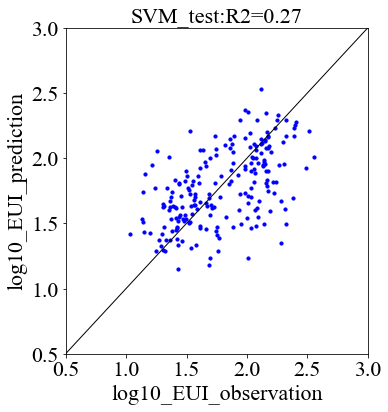

In [21]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(y_test, y_pred, color='b', s=10)    
ax.plot([-10,10],[-10,10], color='k', linewidth=1)
ax.set_xlim([0.5,3])
ax.set_ylim([0.5,3])
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title("SVM_test:R2=0.27", fontsize=22)
ax.set_xlabel("log10_EUI_observation", fontsize=22)
ax.set_ylabel("log10_EUI_prediction", fontsize=22)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.subplots_adjust(left=0.2,right=0.9)

plt.show()
plt.close()